In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import utils
import os
import math
import random
import utils_proj1

In [2]:
from utils import cut # default cut function for seam finding section
from PIL import Image

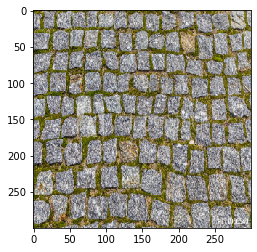

In [3]:
sample_img_dir = 'samples/pattern_1.jpg' # feel free to change
image1 = None
if os.path.exists(sample_img_dir):
    image1 = cv2.imread(sample_img_dir)
    image1 = cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
    image1 = cv2.resize(image1,(300,300))
    plt.imshow(image1)
    


In [4]:
def quilt_random(sample, out_size, patch_size, overlap):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
               
    out_img1 = np.zeros((out_size,out_size,3))

    ylimit = np.arange(math.floor((patch_size -1)/ 2) +1,sample.shape[0] - math.floor((patch_size -1)/ 2))
    xlimit = np.arange(math.floor((patch_size -1)/ 2) +1,sample.shape[1] - math.floor((patch_size -1)/ 2))
    
    for i in range(0,out_size - patch_size + 1,patch_size):
        for j in range(0,out_size - patch_size +1,patch_size):
            
            x = random.choice(xlimit)
            y = random.choice(ylimit)
            
            out_img1[i:i+patch_size, j:j+patch_size,:] = sample[y - math.floor((patch_size -1)/ 2) : y + math.floor((patch_size -1)/ 2) + 1 , x - math.floor((patch_size -1)/ 2) : x + math.floor((patch_size -1)/ 2) + 1, :]

    return out_img1
    
    
    
    
    

In [5]:
out_size = 600
patch_size = 101
overlap = 21
res = quilt_random(image1, out_size, patch_size, overlap)


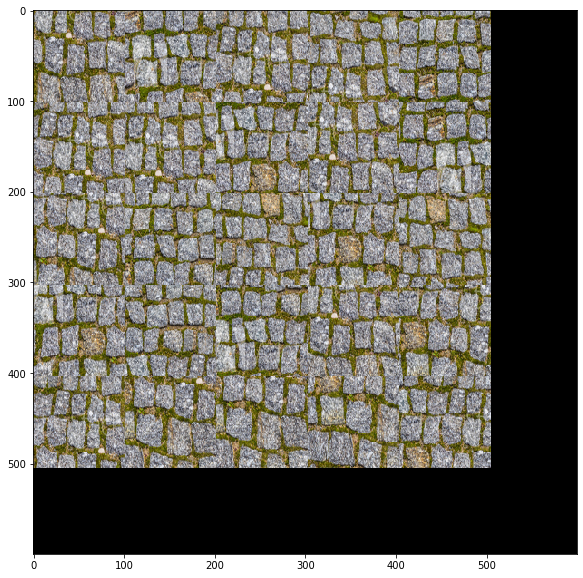

In [6]:
plt.figure(figsize=(20,10))
plt.imshow(res/255)

In [7]:
# ssd_patch performs template matching with the overlapping region, computing the cost of sampling each patch,
# based on the sum of squared differences (SSD) of the overlapping regions of the existing and sampled patch. 
# I suggest using a masked template. The template is the patch in the current output image that is to be filled 
# in (many pixel values will be 0 because they are not filled in yet). The mask has the same size as the patch template
# and has values of 1 in the overlapping region and values of 0 elsewhere. The SSD of the masked template with the 
# input texture image can be computed efficiently using filtering operations (see tips section down below), 
# producing an image in which the output is the overlap cost (SSD) of choosing a sample centered at each pixel.


def ssd_patch(T, M, I):
    
    #I = original image; 
    #M = mask for the template; 
    #T = template in the output to be filled in;it is masked with M to populate 1 in overlap region & zero elsewhere
    #cost = an image of size original image. it consists of overlap costs at each pixel location, as if a sample to fill
    #the template in output, is chosen from the original image, with that pixel at the center
    
#     print("template",T.shape)
#     print("mask",M.shape)
#     print("sample",I.shape)
    
    cost = np.zeros((I.shape[0],I.shape[0]))
    for i in range(3):
        cost += ((M*T[:,:,i])**2).sum() - 2 * cv2.filter2D(I[:,:,i], ddepth=-1, kernel = M*T[:,:,i]) + cv2.filter2D(I[:,:,i] ** 2, ddepth=-1, kernel=M)
    return cost/3

In [8]:
# choose_sample should take as input a cost image (each pixel's value is the cost of selecting the patch centered at 
# that pixel) and select a randomly sampled patch with low cost, as described in the paper. One way to do this is to 
# first find the minimum cost minc and then to sample a patch within a percentage of that value:
# row, col = np.where(cost < minc*(1+tol)) . If the minimum is approximately zero (which can happen initially), 
# it might make sense to set minc to a larger value, e.g., minc=max(minc,small_cost_value);. Another way is to sample 
# one of the K lowest-cost patches.


def choose_sample(sample,cost,patch_size,tol):
    
    
    patch_center = math.floor((patch_size - 1)/2)
    small_cost_value = 0.1
    
    #clipping the cost image to avoid centering on the edge pixels
    cost = cost[patch_center:cost.shape[0] - patch_center,patch_center:cost.shape[0] - patch_center]
    minc = np.amin(cost)
    minc = max(minc, small_cost_value)
    
    y, x = np.where(cost < minc * (1 + tol))

    rand_idx = random.randint(0,len(y)-1)
    y_rand = y[rand_idx]
    x_rand = x[rand_idx]
    
    y_rand = y_rand + patch_center
    x_rand = x_rand + patch_center

    patch = sample[y_rand - patch_center: y_rand + patch_center + 1 , x_rand - patch_center: x_rand + patch_center + 1]
    
   
    return patch   



In [9]:
def quilt_simple(sample,out_size,patch_size,overlap, tol):

# As the next step, let us introduce some overlap in the placement
# of blocks onto the new image. Now, instead of picking a random
# block, we will search SB for such a block that by some measure
# agrees with its neighbors along the region of overlap.

   
    out_img2 = np.zeros((out_size, out_size,3),dtype=np.float64)     
   
    for i in range(0,out_img2.shape[0] - patch_size,patch_size - overlap): 
        for j in range(0,out_img2.shape[1] - patch_size,patch_size - overlap):
            
            mask = np.zeros((patch_size,patch_size), dtype=np.float64)
            
            if(i == 0):
                mask[:,: overlap] = 1
                
            if(j == 0):                
                mask[:overlap] = 1    

            else:
                mask[0:overlap] = 1
                mask[:,0:overlap] = 1
            
            template = out_img2[i:i+patch_size,j:j+patch_size]
            cost = ssd_patch(template, mask, sample)
            out_img2[i:i+patch_size,j:j+patch_size] = choose_sample(sample,cost, patch_size, tol)
            

    return out_img2

            

In [10]:

out_size = 600
patch_size = 101
overlap = 21

sample_img_dir = 'samples/pattern_1.jpg' # feel free to change
image1 = None
if os.path.exists(sample_img_dir):
    image2 = cv2.imread(sample_img_dir)
    image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
    image2 = cv2.resize(image2,(300,300))
    
res2 = quilt_simple(image2,out_size,patch_size,overlap, 0.0001)

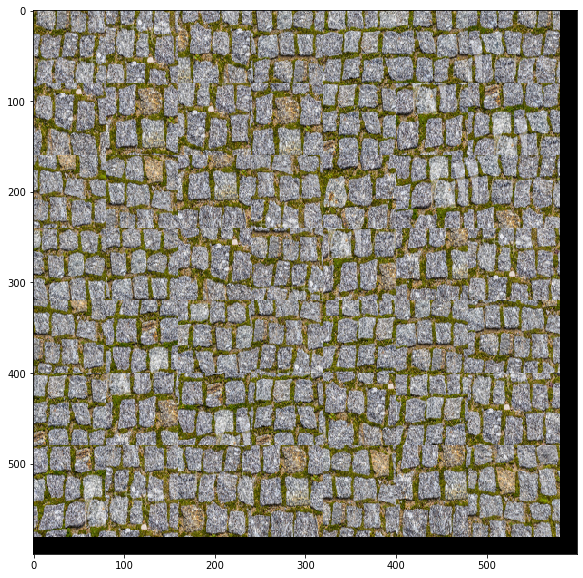

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(res2/255)


In [12]:
# Use the cut function in utils.py (download starter_codes at the top) that finds the min-cost contiguous path 
# from the left to right side of the patch according to the cost indicated by bndcost. The cost of a path through 
# each pixel is the square differences (summed over RGB for color images) of the output image and the newly sampled patch. 
# Note that if a patch has top and left overlaps, you will need to compute two seams, and the mask can be defined as the 
# intersection of the masks for each seam (mask1&mask2). To find a vertical path, you can apply cut to the transposed patch, 
# e.g., cut(bndcost.T).T.



def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """

    out_img3 = np.zeros((out_size, out_size,3),dtype=np.float64)
    mask = np.zeros((patch_size, patch_size))
    cut_mask = np.ones((patch_size, patch_size), dtype=np.float64)
    
 

    
    for row in range(0,out_size - patch_size, patch_size -overlap):
        
        mask1 = mask
        mask1[0 : overlap, :] = 1
        
        template = out_img3[row:row+patch_size,:patch_size]
        cost = ssd_patch(template, mask1, sample)
        patch = choose_sample(sample,cost, patch_size, tol)
        
        h_error = np.sum(np.square(out_img3[row:row+overlap, :patch_size] - patch[:overlap,:patch_size]), axis =2)             
        h_cut = cut(h_error)
 
        cut_mask[:overlap,:] = h_cut
               
        for x in range(row,row+patch_size):
            for y in range(0,patch_size):
                if y >= overlap:
                    out_img3[x,y] = patch[x-row,y]
                else:
                    if cut_mask[x-row,y] != 0:
                        out_img3[x,y] = patch[x-row,y]
        
    
    
    for col in range(0,out_size - patch_size, patch_size -overlap):
    
        mask2 = mask
        mask2[:, 0 : overlap] = 1
        
        template = out_img3[:patch_size,col:col+patch_size]
        cost = ssd_patch(template, mask2, sample)
        patch = choose_sample(sample,cost, patch_size, tol)
    
        v_error = np.sum(np.square(out_img3[:patch_size, col:col+overlap] - patch[:patch_size, :overlap]), axis =2)
        v_cut = cut(v_error.T).T 
        
        
    
    for row in range(0,out_size - patch_size, patch_size -overlap):
        for col in range(0,out_size - patch_size, patch_size -overlap):         

            
            mask3 = mask
            mask3[:,: overlap] = 1
            mask3[:,:overlap] = 1


            template = out_img3[row:row+patch_size,col:col+patch_size]
            cost = ssd_patch(template, mask3, sample)
            patch = choose_sample(sample,cost, patch_size, tol)
            
            if row == 0 and col == 0:
                out_img3[:patch_size,:patch_size] = patch


            v_error2 = np.sum(np.square(out_img3[row:row+patch_size, col:col+overlap] - patch[:patch_size, :overlap]), axis =2)                
            h_error2 = np.sum(np.square(out_img3[row:row+overlap, col:col+patch_size] - patch[:overlap,:patch_size]), axis =2)

            h_cut = cut(h_error2)
            v_cut = cut(v_error2.T).T
            cut_mask[:overlap,:] = h_cut
            cut_mask[:,:overlap] = cut_mask[:,:overlap]*v_cut       



            
            for x in range(row,row+patch_size):
                for y in range(col,col+patch_size):
                    #pdb.set_trace()
                    if y >= col+overlap:
                        out_img3[x,y] = patch[x-row,y-col]
                    else:
                        if cut_mask[x-row,y-col] != 0:
                            out_img3[x,y] = patch[x-row,y-col]

                        
    return out_img3  
 

In [13]:
out_size = 600
patch_size = 101
overlap = 21

sample_img_dir = 'samples/pattern_1.jpg' # feel free to change
image1 = None
if os.path.exists(sample_img_dir):
    image3 = cv2.imread(sample_img_dir)
    image3 = cv2.cvtColor(image3,cv2.COLOR_BGR2RGB)
    image3 = cv2.resize(image3,(300,300))
res3 = quilt_cut(image3,out_size,patch_size,overlap, 0.0001)


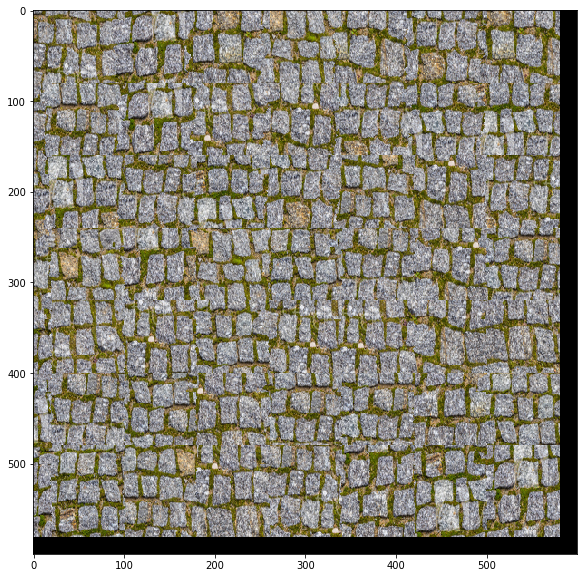

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(res3/255)


In [15]:
def seam_binding(sample, out_size, patch_size, overlap, tol):
    
    out_img3 = np.zeros((out_size, out_size,3),dtype=np.float64)
    mask = np.zeros((patch_size, patch_size))
    cut_mask = np.ones((patch_size, patch_size), dtype=np.float64)
        
    
    for row in range(0,out_size - patch_size, patch_size -overlap):
        
        mask1 = mask
        mask1[0 : overlap, :] = 1
        
        template = out_img3[row:row+patch_size,:patch_size]
        cost = ssd_patch(template, mask1, sample)
        patch = choose_sample(sample,cost, patch_size, tol)
        
        h_error = np.sum(np.square(out_img3[row:row+overlap, :patch_size] - patch[:overlap,:patch_size]), axis =2)             
        h_cut = cut(h_error)
 
        cut_mask[:overlap,:] = h_cut
               
        for x in range(row,row+patch_size):
            for y in range(0,patch_size):
                if y >= overlap:
                    out_img3[x,y] = patch[x-row,y]
                else:
                    if cut_mask[x-row,y] != 0:
                        out_img3[x,y] = patch[x-row,y]
        
    
    
    for col in range(0,out_size - patch_size, patch_size -overlap):
    
        mask2 = mask
        mask2[:, 0 : overlap] = 1
        
        template = out_img3[:patch_size,col:col+patch_size]
        cost = ssd_patch(template, mask2, sample)
        patch = choose_sample(sample,cost, patch_size, tol)
    
        v_error = np.sum(np.square(out_img3[:patch_size, col:col+overlap] - patch[:patch_size, :overlap]), axis =2)
        v_cut = cut(v_error.T).T     
    
    
        max = np.amax(v_error)
        start = 0
        for i in range(v_cut.shape[0]):
            for j in range(v_cut.shape[1]):
                if start!= v_cut[i, j]:
                    v_error[i, j] = max
                start = v_cut[i, j]  

        plt.figure(figsize=(7,3))

        plt.subplot(141)
        plt.imshow(out_img3[row:row+patch_size, col:col+overlap]/255)
        plt.title('Left')
        plt.xticks([], [])
        plt.yticks([], [])

        plt.subplot(142)
        plt.imshow(patch[:, :overlap])
        plt.title('Right')
        plt.xticks([], [])
        plt.yticks([], [])

        plt.subplot(143)
        plt.imshow(v_cut, cmap = 'gist_gray')
        plt.title('Path')
        plt.xticks([], [])
        plt.yticks([], [])

        plt.subplot(144)
        plt.imshow(v_error)
        plt.title('Cost with Path')
        plt.xticks([], [])
        plt.yticks([], [])
    


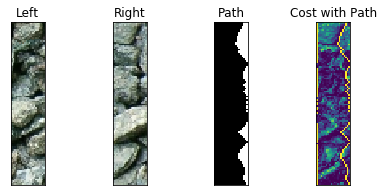

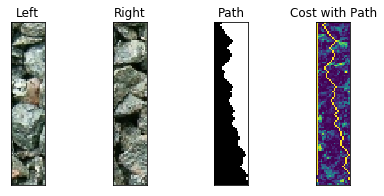

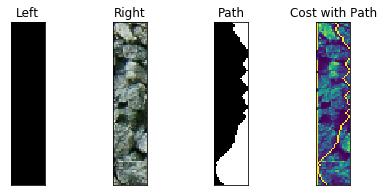

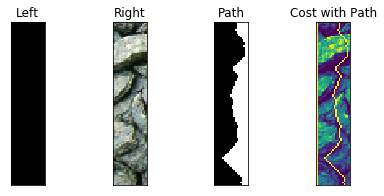

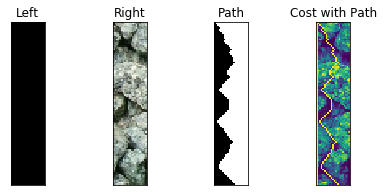

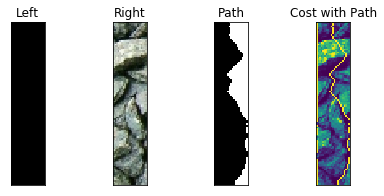

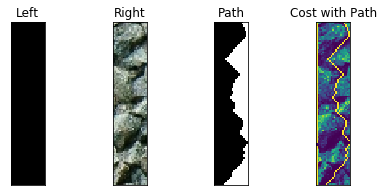

In [16]:
out_size = 600
patch_size = 101
overlap = 21

sample_img_dir = 'samples/sample.jpg' # feel free to change
image1 = None
if os.path.exists(sample_img_dir):
    image4 = cv2.imread(sample_img_dir)
    image4 = cv2.cvtColor(image4,cv2.COLOR_BGR2RGB)
    image4 = cv2.resize(image4,(300,300))
    
res3 = seam_binding(image4,out_size,patch_size,overlap, 0.0001)

In [17]:
def texture_transfer(sample, target, patch_size, overlap, alpha, tol):
    """
    Feel free to add function parameters   
    
    """    
    
    out_img4 = np.zeros((target.shape[0], target.shape[0],3),dtype=np.float64)
    mask = np.zeros((patch_size, patch_size))
    cut_mask = np.ones((patch_size, patch_size), dtype=np.float64)
    
 

    
    for row in range(0,target.shape[0] - patch_size, patch_size -overlap):
        
        mask1 = mask
        mask1[0 : overlap, :] = 1
        
        template = out_img4[row:row+patch_size,:patch_size]
        cost = ssd_patch(template, mask1, sample)+ ssd_patch(target[row:row+patch_size, :patch_size], cut_mask,sample)
        patch = choose_sample(sample,cost, patch_size, tol)
        
        h_error = np.sum(np.square(out_img4[row:row+overlap, :patch_size] - patch[:overlap,:patch_size]), axis =2)             
        h_cut = cut(h_error)
 
        cut_mask[:overlap,:] = h_cut
               
        for x in range(row,row+patch_size):
            for y in range(0,patch_size):
                if y >= overlap:
                    out_img4[x,y] = patch[x-row,y]
                else:
                    if cut_mask[x-row,y] != 0:
                        out_img4[x,y] = patch[x-row,y]
        
    
    
    for col in range(0,target.shape[0] - patch_size, patch_size -overlap):
    
        mask2 = mask
        mask2[:, 0 : overlap] = 1
        
        template = out_img4[:patch_size,col:col+patch_size]
        cost = ssd_patch(template, mask2, sample)+ ssd_patch(target[:patch_size, col:col+patch_size], cut_mask, sample)
        patch = choose_sample(sample,cost, patch_size, tol)
    
        v_error = np.sum(np.square(out_img4[:patch_size, col:col+overlap] - patch[:patch_size, :overlap]), axis =2)
        v_cut = cut(v_error.T).T 
        
        
    
    for row in range(0,target.shape[0] - patch_size, patch_size -overlap):
        for col in range(0,target.shape[0] - patch_size, patch_size -overlap):         

            
            mask3 = mask
            mask3[:,: overlap] = 1
            mask3[:,:overlap] = 1


            template = out_img4[row:row+patch_size,col:col+patch_size]
            cost = ssd_patch(template, mask3, sample)+ ssd_patch(target[row:row+patch_size, col:col+patch_size], cut_mask, sample)
            patch = choose_sample(sample,cost, patch_size, tol)
            
            if row == 0 and col == 0:
                out_img4[:patch_size,:patch_size] = patch


            v_error2 = np.sum(np.square(out_img4[row:row+patch_size, col:col+overlap] - patch[:patch_size, :overlap]), axis =2)                
            h_error2 = np.sum(np.square(out_img4[row:row+overlap, col:col+patch_size] - patch[:overlap,:patch_size]), axis =2)

            h_cut = cut(h_error2)
            v_cut = cut(v_error2.T).T
            cut_mask[:overlap,:] = h_cut
            cut_mask[:,:overlap] = cut_mask[:,:overlap]*v_cut       



            
            for x in range(row,row+patch_size):
                for y in range(col,col+patch_size):
                    #pdb.set_trace()
                    if y >= col+overlap:
                        out_img4[x,y] = patch[x-row,y-col]
                    else:
                        if cut_mask[x-row,y-col] != 0:
                            out_img4[x,y] = patch[x-row,y-col]

                        
    return out_img4          
    
    


In [18]:
sample = cv2.imread('samples/sketch.tiff')
sample = cv2.cvtColor(sample,cv2.COLOR_BGR2RGB)
sample = cv2.resize(sample,(300,300))
target = cv2.imread('samples/feynman.tiff')
target = cv2.cvtColor(target,cv2.COLOR_BGR2RGB)
target= cv2.resize(target,(300,300))

sample = np.array(sample, dtype='float64')
sample = cv2.blur(sample,(5,5))
target = np.array(target, dtype='float64')

patch_size = 21
overlap = 5

res4 = texture_transfer(sample,target,patch_size,overlap, alpha = 0.6, tol = 0.0001)


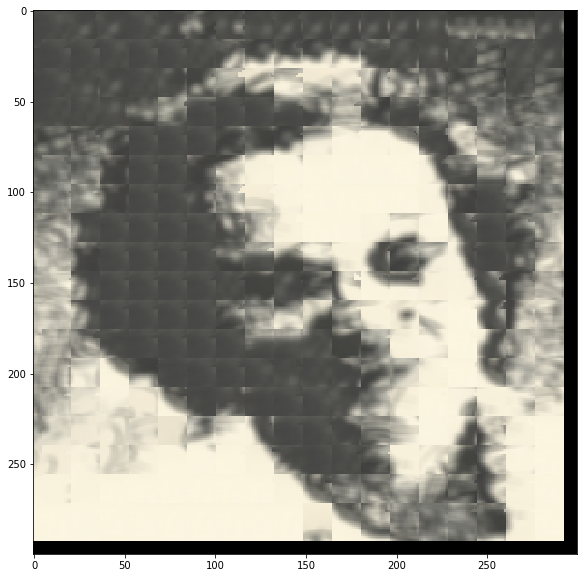

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(res4/255)



# Bells & Whistles

# Iterative Texture Transfer

In [20]:
def texture_transfer_iterative(sample, target,last_img, patch_size, overlap, alpha, tol):
    """
    Feel free to add function parameters   
    
    """
    
    out_img5 = last_img.copy()
    mask = np.zeros((patch_size, patch_size))
    cut_mask = np.ones((patch_size, patch_size), dtype=np.float64)
    
 

    
    for row in range(0,target.shape[0] - patch_size, patch_size -overlap):
        
        mask1 = mask
        mask1[0 : overlap, :] = 1
        
        template = out_img5[row:row+patch_size,:patch_size]
        cost = alpha*ssd_patch(template, mask1, sample)+ (1-alpha)*ssd_patch(target[row:row+patch_size, :patch_size], cut_mask,sample)
        patch = choose_sample(sample,cost, patch_size, tol)
        
        h_error = np.sum(np.square(out_img5[row:row+overlap, :patch_size] - patch[:overlap,:patch_size]), axis =2)             
        h_cut = cut(h_error)
 
        cut_mask[:overlap,:] = h_cut
               
        for x in range(row,row+patch_size):
            for y in range(0,patch_size):
                if y >= overlap:
                    out_img5[x,y] = patch[x-row,y]
                else:
                    if cut_mask[x-row,y] != 0:
                        out_img5[x,y] = patch[x-row,y]
        
    
    
    for col in range(0,target.shape[0] - patch_size, patch_size -overlap):
    
        mask2 = mask
        mask2[:, 0 : overlap] = 1
        
        template = out_img5[:patch_size,col:col+patch_size]
        cost = alpha*ssd_patch(template, mask2, sample)+ (1-alpha)*ssd_patch(target[:patch_size, col:col+patch_size], cut_mask, sample)
        patch = choose_sample(sample,cost, patch_size, tol)
    
        v_error = np.sum(np.square(out_img5[:patch_size, col:col+overlap] - patch[:patch_size, :overlap]), axis =2)
        v_cut = cut(v_error.T).T 
        
        
    
    for row in range(0,target.shape[0] - patch_size, patch_size -overlap):
        for col in range(0,target.shape[0] - patch_size, patch_size -overlap):         

            
            mask3 = mask
            mask3[:,: overlap] = 1
            mask3[:,:overlap] = 1


            template = out_img5[row:row+patch_size,col:col+patch_size]
            cost = alpha*ssd_patch(template, mask3, sample)+ (1-alpha)*ssd_patch(target[row:row+patch_size, col:col+patch_size], cut_mask, sample)
            patch = choose_sample(sample,cost, patch_size, tol)
            
            if row == 0 and col == 0:
                out_img5[:patch_size,:patch_size] = patch


            v_error2 = np.sum(np.square(out_img5[row:row+patch_size, col:col+overlap] - patch[:patch_size, :overlap]), axis =2)                
            h_error2 = np.sum(np.square(out_img5[row:row+overlap, col:col+patch_size] - patch[:overlap,:patch_size]), axis =2)

            h_cut = cut(h_error2)
            v_cut = cut(v_error2.T).T
            cut_mask[:overlap,:] = h_cut
            cut_mask[:,:overlap] = cut_mask[:,:overlap]*v_cut       



            
            for x in range(row,row+patch_size):
                for y in range(col,col+patch_size):
                    #pdb.set_trace()
                    if y >= col+overlap:
                        out_img5[x,y] = patch[x-row,y-col]
                    else:
                        if cut_mask[x-row,y-col] != 0:
                            out_img5[x,y] = patch[x-row,y-col]

                        
    return out_img5          


In [21]:
sample = cv2.imread('samples/sketch.tiff')
sample = cv2.cvtColor(sample,cv2.COLOR_BGR2RGB)
sample = cv2.resize(sample,(300,300))
target = cv2.imread('samples/feynman.tiff')
target = cv2.cvtColor(target,cv2.COLOR_BGR2RGB)
target= cv2.resize(target,(300,300))

sample = np.array(sample, dtype='float64')
sample = cv2.blur(sample,(5,5))
target = np.array(target, dtype='float64')

N = 3
patch_size = 25

new_im = np.zeros((target.shape[0], target.shape[0], 3), dtype=np.float64)

for i in range(N):
    new_im = texture_transfer_iterative(sample, target, new_im, int(patch_size/(1.8**i)), int(patch_size/(2**i)/4), 0.8*(i-1)/(N-1) + 0.1, 0.0002)



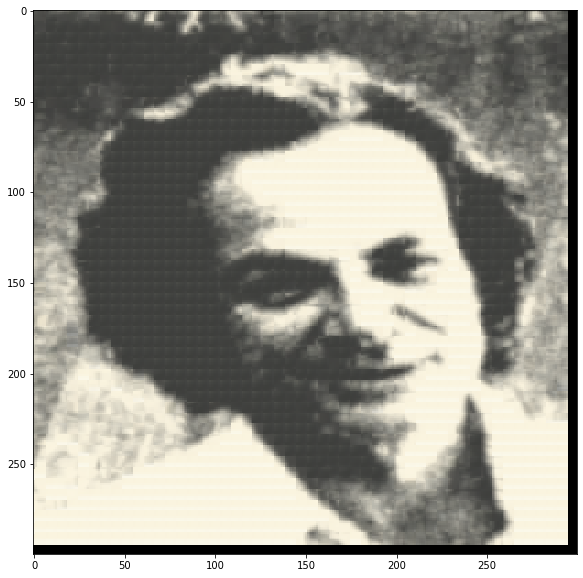

In [22]:
plt.figure(figsize=(20,10))
plt.imshow(new_im/255)

# Blending and Text Transfer

In [23]:
sample = cv2.imread('samples/toast.jpg')
sample = cv2.cvtColor(sample,cv2.COLOR_BGR2RGB)
sample = cv2.resize(sample,(300,300))
target = cv2.imread('samples/lincoln.jpg')
target = cv2.cvtColor(target,cv2.COLOR_BGR2RGB)
target= cv2.resize(target,(300,300))

sample = np.array(sample, dtype='float64')
sample = cv2.blur(sample,(5,5))
target = np.array(target, dtype='float64')

N = 3
patch_size = 25

new_im = np.zeros((target.shape[0], target.shape[0], 3), dtype=np.float64)

for i in range(N):
    new_im = texture_transfer_iterative(sample, target, new_im, int(patch_size/(1.8**i)), int(patch_size/(2**i)/4), 0.8*(i-1)/(N-1) + 0.1, 0.0002)


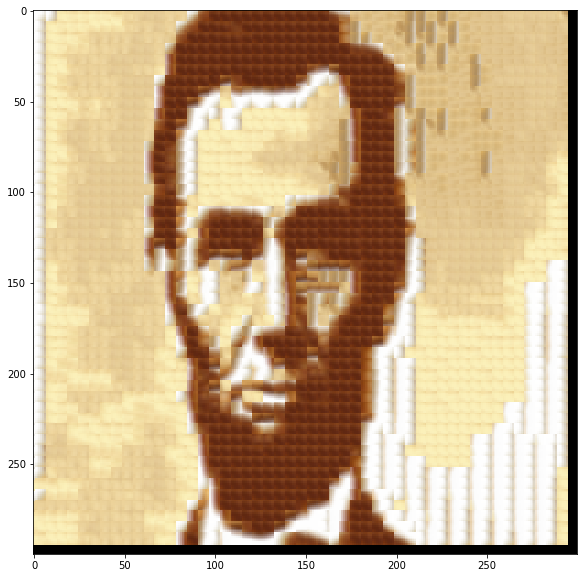

In [24]:
plt.figure(figsize=(20,10))
plt.imshow(new_im/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)
(225, 225, 3)
(300, 300, 3)


([], <a list of 0 Text yticklabel objects>)

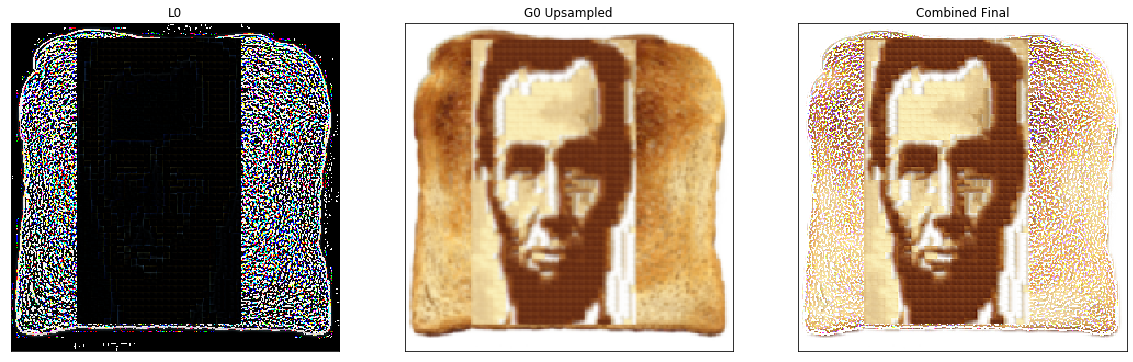

In [25]:
target = cv2.imread('samples/toast.jpg')
target = cv2.cvtColor(target,cv2.COLOR_BGR2RGB)
target = cv2.resize(target,(300,300))
# sample = cv2.imread('samples/lincoln.jpg')
# sample = cv2.cvtColor(target,cv2.COLOR_BGR2RGB)
# sample = cv2.resize(target,(300,300))


cutoff_low = 1
lpf_low = utils_proj1.gaussian_kernel(cutoff_low, 3*cutoff_low)

scale_percent = 75 # percent of original size
width = int(new_im.shape[1] * scale_percent / 100)
height = int(new_im.shape[0] * scale_percent / 100)
dim = (width, height)

im_blurA = np.zeros((new_im.shape[0],sample.shape[1],3))
im_blurA = cv2.filter2D(new_im,-1,lpf_low)
A1 = cv2.resize(im_blurA, dim, interpolation = cv2.INTER_NEAREST)  ##### A1
A0 = new_im - im_blurA

im_blurB = np.zeros((target.shape[0],target.shape[1],3))
im_blurB = cv2.filter2D(target,-1,lpf_low)
B1 = cv2.resize(im_blurB, dim, interpolation = cv2.INTER_NEAREST)  ##### B1
B0 = target - im_blurB

M0 = np.zeros((target.shape[0],target.shape[0],3), dtype=np.float64)

M0[15:275,60:210] = 1

L0 = A0*M0 + B0*(1-M0)
print(L0.shape)


##blur mask and downsample

widthM = int(M0.shape[1] * scale_percent / 100)
heightM = int(M0.shape[0] * scale_percent / 100)
dimM = (widthM, heightM)

im_blurM = np.zeros((M0.shape[0],M0.shape[1],3))
im_blurM = cv2.filter2D(M0,-1,lpf_low)
M1 = cv2.resize(im_blurM, dimM, interpolation = cv2.INTER_NEAREST)  ##### blurred & downsampled mask


G0 = A1*M1 + B1*(1-M1)
print(G0.shape)
#plt.imshow(L1/255)

G0_up = cv2.resize(G0, (L0.shape[1],L0.shape[0]), interpolation = cv2.INTER_NEAREST)  ##### B1
print(G0_up.shape)


final = G0_up + L0

plt.figure(figsize=(20,10))

plt.subplot(131)
plt.imshow(L0/255)
plt.title('L0')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(132)
plt.imshow(G0_up/255)
plt.title('G0 Upsampled')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(133)
plt.imshow(final/255)
plt.title('Combined Final')
plt.xticks([], [])
plt.yticks([], [])

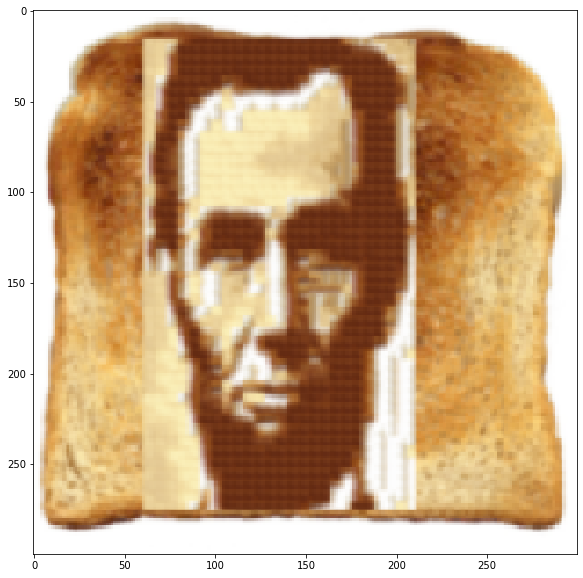

In [26]:
plt.figure(figsize=(20,10))
plt.imshow(G0_up/255)

In [34]:
iterations = 3
block0 = 25

new_im2 = np.zeros((target.shape[0], target.shape[0], 3), dtype=np.float64)

for i in range(iterations):
    new_im2 = texture_transfer_iterative( new_im, G0_up, new_im2, int(block0/(1.8**i)), int(block0/(2**i)/4), 0.0002, .0002*(i+1))

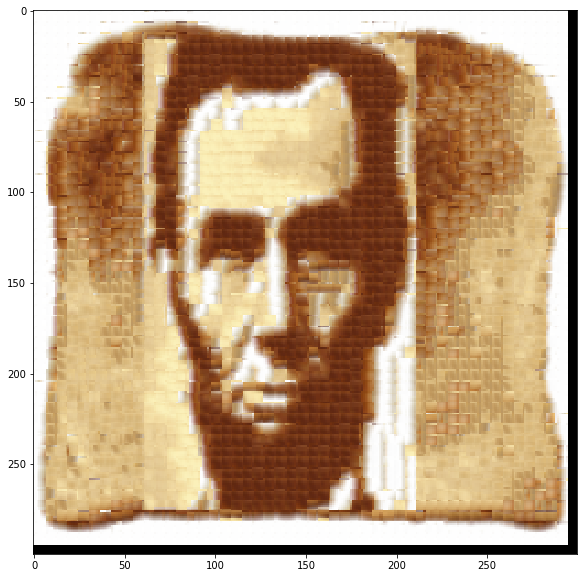

In [35]:
plt.figure(figsize=(20,10))
plt.imshow(new_im2/255)